Sheet 8.2: Using 🤗's pretrained models for image captioning
===========================================================

**Author:** Michael Franke



In this tutorial, we will learn how to use 🤗&rsquo;s &rsquo;transformers&rsquo; package to access large and powerful pre-trained image processing and language models.
We learn how to instantiate a pre-trained architecture, how to get predictions for arbitrary input, and how to fine-tune the pre-trained models for the A3DS data set.

We use the &ldquo;nlpconnect/vit-gpt2-image-captioning&rdquo; pre-trained image captioner, which uses an instance of VIT for image encoding and GTP-2 for decoding via causal language modeling.



## Necessary files



You need additional files to run the code in this notebook.
If you are on CoLab use these commands to install.
(Check if the files are installed in the right directory (&rsquo;A3DS&rsquo;) after unzipping).



In [1]:
!wget https://github.com/michael-franke/npNLG/raw/main/neural_pragmatic_nlg/data/A3DS/A3DS.zip
!unzip A3DS.zip

--2023-01-11 10:25:38--  https://github.com/michael-franke/npNLG/raw/main/neural_pragmatic_nlg/data/A3DS/A3DS.zip
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/michael-franke/npNLG/main/neural_pragmatic_nlg/data/A3DS/A3DS.zip [following]
--2023-01-11 10:25:38--  https://raw.githubusercontent.com/michael-franke/npNLG/main/neural_pragmatic_nlg/data/A3DS/A3DS.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 31636302 (30M) [application/zip]
Saving to: ‘A3DS.zip’

A3DS.zip            100%[===================>]  30.17M  --.-KB/s    in 0.07s   

2023-01-11 10:25:38 (446 MB/s) - ‘A3DS.zip’ saved [3

In [3]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 97.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.4/182.4 KB 26.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 110.7 MB/s eta 0:00:00


## Packages



In [4]:
##################################################
## import packages
##################################################

from transformers import GPT2TokenizerFast, ViTImageProcessor, VisionEncoderDecoderModel
from torch.utils.data import Dataset
from torchtext.data import get_tokenizer
import requests
import torch
import numpy as np
from PIL import Image
import pickle
# from torchvision import transforms
# from datasets import load_dataset
# import torch.nn as nn
import matplotlib.pyplot as plt
import os
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

We need to import the general &rsquo;VisionEncoderDecoderModel&rsquo; module from the &rsquo;transformers&rsquo; package, as well as the tokenizer for the decoder and the image processor for the encoder component (here GPT2 and VIT).
The &rsquo;requests&rsquo; package allows us to open pictures from URLs (which is tons of fun when generating captions for images).



## Loading the pretrained model and its helper components



We load the pre-trained neural image captioner like so:



In [5]:
model_raw = VisionEncoderDecoderModel.from_pretrained("nlpconnect/vit-gpt2-image-captioning")

Downloading:   0%|          | 0.00/4.61k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/982M [00:00<?, ?B/s]

In order to be able to feed this image+language model with images and language, we need an image processor and a tokenizer that fits the model components used for encoding and decoding.



In [6]:
image_processor = ViTImageProcessor.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
tokenizer       = GPT2TokenizerFast.from_pretrained("nlpconnect/vit-gpt2-image-captioning")

Downloading:   0%|          | 0.00/228 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/241 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/798k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/120 [00:00<?, ?B/s]

## Generating captions



You can insert URLs for pictures of your liking in this code to generate captions:



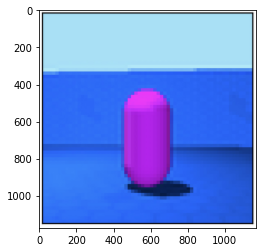

a yellow bottle sitting next to a blue and white object 


In [12]:
def show_n_generate(url, greedy = True, model = model_raw):
    image = Image.open(requests.get(url, stream =True).raw)
    pixel_values   = image_processor(image, return_tensors ="pt").pixel_values
    plt.imshow(np.asarray(image))
    plt.show()

    if greedy:
        generated_ids  = model.generate(pixel_values, max_new_tokens = 30)
    else:
        generated_ids  = model.generate(
            pixel_values,
            do_sample=True,
            max_new_tokens = 30,
            top_k=5)
    generated_text = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]
    print(generated_text)

# url = "http://images.cocodataset.org/val2017/000000039769.jpg"
url = "https://raw.githubusercontent.com/michael-franke/npNLG/main/neural_pragmatic_nlg/pics/06-3DS-example.jpg"
# url = "https://img.welt.de/img/sport/mobile102025155/9292509877-ci102l-w1024/hrubesch-rummenigge-BM-Berlin-Gijon-jpg.jpg"
# url = "https://faroutmagazine.co.uk/static/uploads/2021/09/The-Cover-Uncovered-The-severity-of-Rage-Against-the-Machines-political-message.jpg"
# url = "https://media.npr.org/assets/img/2022/03/13/2ukraine-stamp_custom-30c6e3889c98487086d76869f8ba6a8bfd2fd5a1.jpg"

show_n_generate(url, greedy = False)

> <strong><span style=&ldquo;color:#D83D2B;&rdquo;>Exercise 8.2.1: Explore predictions of pre-trained model</span></strong>
>
> 0. [Just for yourselves] Explore the predictions for different pictures. Make sure to also try out stochastic predictions (setting the parameter &rsquo;greedy&rsquo; to &rsquo;False&rsquo;) for the 3D-shape picture. How truthful / adequate are the descriptions in general? Do they tell you a bit about what this model was trained on?



## Fine-tuning on the A3DS data set



The following code gives us PyTorch &rsquo;Dataset&rsquo; and &rsquo;DataLoader&rsquo; objects, with which to handle a 1k-subset of images and annotations from the A3DS data set.
It is the same as in Sheet 8.1.



### The &rsquo;Dataset&rsquo; object



Here is the definition of the &rsquo;Dataset&rsquo; object.



In [8]:
class A3DS(Dataset):
    """
    Dataset class for loading the dataset of images and captions from the 3dshapes dataset.

    Arguments:
    ---------
    num_labels: int
        Number of distinct captions to sample for each image. Relevant for using the dataloader for training models.
    labels_type: str
        "long" or "short". Indicates whether long or short captions should be used.
    run_inference: bool
        Flag indicating whether this dataset will be used for performing inference with a trained image captioner.
    batch_size: int
        Batch size. Has to be 1 in order to save the example image-caption pairs.
    vocab_file: str
        Name of vocab file.
    start_token: str
        Start token.
    end_token: str
        End token.
    unk_token: str
        Token to be used when encoding unknown tokens.
    pad_token: str
        Pad token to be used for padding captions tp max_sequence_length.
    max_sequence_length: int
        Length to which all captions are padded / truncated.
    """
    def __init__(
            self,
            path="A3DS",
            num_labels=1, # number of ground truth labels to retrieve per image
            labels_type="long", # alternative: short
            run_inference=False, # depending on this flag, check presence of model weights
            batch_size=1,
            vocab_file="vocab.pkl",
            start_token="START",  # might be unnecessary since vocab file is fixed anyways
            end_token="END",
            unk_token="UNK",
            pad_token="PAD",
            max_sequence_length=26, # important for padding length
        ):

        # check vocab file exists
        assert os.path.exists(os.path.join(path, vocab_file)), "Make sure the vocab file exists in the directory passed to the dataloader (see README)"

        # check if image file exists
        assert (os.path.exists(os.path.join(path, "sandbox_3Dshapes_1000.pkl")) and os.path.join(path, "sandbox_3Dshapes_resnet50_features_1000.pt")), "Make sure the sandbox dataset exists in the directory passed to the dataloader (see README)"

        if labels_type == "long":
            assert num_labels <= 20, "Maximally 20 distinct image-long caption pairs can be created for one image"
        else:
            assert num_labels <= 27, "Maximally 27 distinct image-short caption pairs can be created for one image"

        self.batch_size = batch_size
        with open(os.path.join(path, vocab_file), "rb") as vf:
            self.vocab = pickle.load(vf)

        self.max_sequence_length = max_sequence_length
        self.start_token = start_token
        self.end_token = end_token
        self.unk_token = unk_token
        self.pad_token = pad_token
        self.tokenizer = get_tokenizer("basic_english")

        self.embedded_imgs = torch.load(os.path.join(path, "sandbox_3Dshapes_resnet50_features_1000.pt"))
        with open(os.path.join(path, "sandbox_3Dshapes_1000.pkl"), "rb") as f:
            self.sandbox_file = pickle.load(f)
            self.images = self.sandbox_file["images"]
            self.numeric_labels = self.sandbox_file["labels_numeric"]
            self.labels_long = self.sandbox_file["labels_long"]
            self.labels_short = self.sandbox_file["labels_short"]

        if labels_type == "long":
            labels_ids_flat = [list(np.random.choice(range(len(self.labels_long[0])), num_labels, replace=False)) for i in range(len(self.images))]
            self.labels_flat = [self.labels_long[i][l] for i, sublst in enumerate(labels_ids_flat) for l in sublst]
            self.img_ids_flat = [id for id in range(len(self.images)) for i in range(num_labels)]
        else:
            labels_ids_flat = [list(np.random.choice(range(len(self.labels_short[0])), num_labels, replace=False)) for i in range(len(self.images))]
            self.labels_flat = [self.labels_short[i][l] for i, sublst in enumerate(labels_ids_flat) for l in sublst]
            self.img_ids_flat = [id for id in range(len(self.images)) for i in range(num_labels)]

        # print("len labels ids flat ", len(labels_ids_flat))
        # print("len labels flat ", len(self.labels_flat), self.labels_flat[:5])
        # print("len image ids flat ", len(self.img_ids_flat), self.img_ids_flat[:5])

    def __len__(self):
        """
        Returns length of dataset.
        """
        return len(self.img_ids_flat)

    def __getitem__(self, idx):
        """
        Iterator over the dataset.

        Arguments:
        ---------
        idx: int
            Index for accessing the flat image-caption pairs.

        Returns:
        -------
        target_img: np.ndarray (64,64,3)
            Original image.
        target_features: torch.Tensor(2048,)
            ResNet features of the image.
        target_lbl: str
            String caption.
        numeric_lbl: np.ndarray (6,)
            Original numeric image annotation.
        target_caption: torch.Tensor(batch_size, 25)
            Encoded caption.
        """
        # access raw image corresponding to the index in the entire dataset
        target_img = self.images[self.img_ids_flat[idx]]
        # access caption
        target_lbl = self.labels_flat[idx]
        # access original numeric annotation of the image
        numeric_lbl = self.numeric_labels[self.img_ids_flat[idx]]
        # cast type
        target_img = np.asarray(target_img).astype('uint8')
        # retrieve ResNet features, accessed through original image ID
        target_features = self.embedded_imgs[self.img_ids_flat[idx]]
        # tokenize label
        tokens = self.tokenizer(str(target_lbl).lower().replace("-", " "))
        # Convert caption to tensor of word ids, append start and end tokens.
        target_caption = self.tokenize_caption(tokens)
        # convert to tensor
        target_caption = torch.Tensor(target_caption).long()

        return target_img, target_features, target_lbl, numeric_lbl, target_caption

    def tokenize_caption(self, label):
        """
        Helper for converting list of tokens into list of token IDs.
        Expects tokenized caption as input.

        Arguments:
        --------
        label: list
            Tokenized caption.

        Returns:
        -------
        tokens: list
            List of token IDs, prepended with start, end, padded to max length.
        """
        label = label[:(self.max_sequence_length-2)]
        tokens = [self.vocab["word2idx"][self.start_token]]
        for t in label:
            try:
                tokens.append(self.vocab["word2idx"][t])
            except:
                tokens.append(self.vocab["word2idx"][self.unk_token])
        tokens.append(self.vocab["word2idx"][self.end_token])
        # pad
        while len(tokens) < self.max_sequence_length:
            tokens.append(self.vocab["word2idx"][self.pad_token])

        return tokens

    def get_labels_for_image(self, id, caption_type="long"):
        """
        Helper for getting all annotations for a given image id.

        Arguments:
        ---------
        id: int
            Index of image caption pair containing the image
            for which the full list of captions should be returned.
        caption_type: str
            "long" or "short". Indicates type of captions to provide.

        Returns:
        -------
            List of all captions for given image.
        """
        if caption_type == "long":
            return self.labels_long[self.img_ids_flat[id]]
        else:
            return self.labels_short[self.img_ids_flat[id]]

A3DS_dataset = A3DS()
vocab = A3DS_dataset.vocab["word2idx"].keys()
vocab_size = len(vocab)

### Creating a &rsquo;DataLoader&rsquo;



Let&rsquo;s create a &rsquo;DataLoader&rsquo; for batches of a specified size, using a random shuffle of the data.
(The current code requires a batch size of 1, unfortunately.)



In [9]:
batch_size = 1
A3DS_data_loader = torch.utils.data.DataLoader(
    dataset    = A3DS_dataset,
    batch_size = batch_size,
    shuffle    = True,
)

### Fine-tuning training



For fine-tuning, we just iterate once through the whole 1k subset of the A3DS.
(This might take some 15-20 minutes, depending on your machine.)



In [ ]:
model_trained = VisionEncoderDecoderModel.from_pretrained("nlpconnect/vit-gpt2-image-captioning")

optimizer = torch.optim.Adam(model_trained.parameters(), lr=1e-4)

for i in tqdm(range(len(A3DS_data_loader.dataset))):
    # get the next training instance
    x = next(iter(A3DS_data_loader))

    # retrieve and preprocess image
    image = x[0][0]
    image = Image.fromarray(image.detach().numpy()) # TODO: necessary?
    pixel_values = image_processor(image, return_tensors="pt").pixel_values

    # retrieve and preprocess labels
    labels = x[2][0]
    labels = tokenizer(labels, return_tensors="pt").input_ids

    # compute loss
    loss = model_trained(pixel_values=pixel_values, labels=labels).loss

    # parameter update
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

100% 1000/1000 [12:42<00:00,  1.31it/s]

Let&rsquo;s try again the model predictions with the previous example (which is not in the training data set):



the pink pill on medium blue floor close to the middle in front of a medium blue wall is small-sized pink wall in the middle is small-

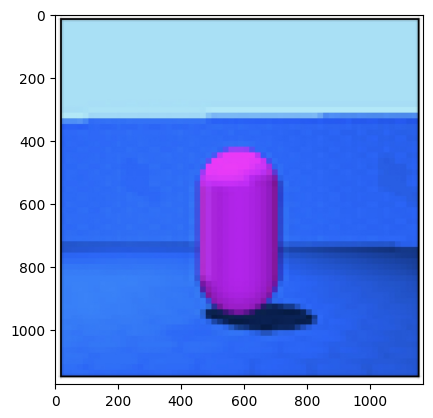

In [ ]:
url = "https://raw.githubusercontent.com/michael-franke/npNLG/main/neural_pragmatic_nlg/pics/06-3DS-example.jpg"

show_n_generate(url, greedy = False, model = model_trained)